# Fine Tuning Pre-Existing Model

In [2]:
import os
import re
import random
import io
import urllib.request

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL

from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from keras.applications import VGG16

from IPython.display import display, HTML

Using TensorFlow backend.


In [3]:
data_dir  = os.path.join("var", "data")
train_dir = os.path.join(data_dir, "train")
val_dir   = os.path.join(data_dir, "validation")
test_dir  = os.path.join(data_dir, "test")
model_dir = os.path.join("var", "model")

os.makedirs(model_dir, exist_ok=True)

In [4]:
def get_conv_base():
    return VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [11]:
conv_base = get_conv_base()

conv_base.trainable = True
for layer in conv_base.layers:
    if layer.name.startswith("block5"):
        layer.trainable = True
        print("Making layer: {} trainable.".format(layer.name))
    else:
        layer.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

#optimizer = optimizers.Adam(lr=0.001)
optimizer = optimizers.RMSprop(lr=2e-5)

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['acc'])

model.summary()

Making layer: block5_conv1 trainable.
Making layer: block5_conv2 trainable.
Making layer: block5_conv3 trainable.
Making layer: block5_pool trainable.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

#train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 23s 226ms/step - loss: 0.4846 - acc: 0.7505 - val_loss: 0.3143 - val_acc: 0.8760
Epoch 2/100
100/100 [==============================] - 22s 222ms/step - loss: 0.3453 - acc: 0.8410 - val_loss: 0.1495 - val_acc: 0.9050
Epoch 3/100
100/100 [==============================] - 22s 223ms/step - loss: 0.3048 - acc: 0.8695 - val_loss: 0.3512 - val_acc: 0.9150
Epoch 4/100
100/100 [==============================] - 22s 223ms/step - loss: 0.2625 - acc: 0.8885 - val_loss: 0.0571 - val_acc: 0.8930
Epoch 5/100
100/100 [==============================] - 22s 223ms/step - loss: 0.2528 - acc: 0.8920 - val_loss: 0.0711 - val_acc: 0.9230
Epoch 6/100
100/100 [==============================] - 22s 224ms/step - loss: 0.2250 - acc: 0.9060 - val_loss: 0.2002 - val_acc: 0.9120
Epoch 7/100
100/100 [==============================] - 22s 224ms/step - loss: 0.2027 - acc: 0.9130 - val_loss: 0.1604 - val_acc: 0.9050
Epoch 8/100
100/100 [===========================

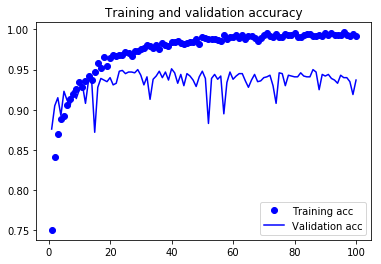

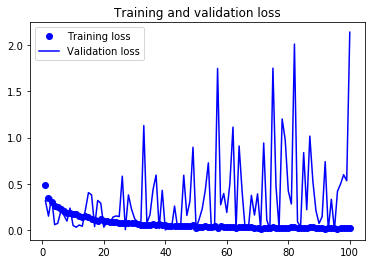

In [14]:
def display_training_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
display_training_history(history)

In [15]:
model.save('{}/cats_and_dogs_small_5.h5'.format(model_dir))